In [2]:
# Add the repo root to the sys path for the model import below
import sys

sys.path.append(r"C:\Users\coach\myfiles\postdoc\Fire\clay\model")

In [3]:
import math

import geopandas as gpd
import numpy as np
import pandas as pd
import pystac_client
import stackstac
import torch
import yaml
from box import Box
from matplotlib import pyplot as plt
from rasterio.enums import Resampling
from shapely import Point
from sklearn import decomposition, svm
from torchvision.transforms import v2

In [4]:
from model import ClayMAEModule

In [6]:
# Point over Monchique Portugal
lat, lon = 37.30939, -8.57207

# Dates of a large forest fire
start = "2018-07-01"
end = "2018-09-01"

In [7]:
STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"

# Search the catalogue
catalog = pystac_client.Client.open(STAC_API)
search = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start}/{end}",
    bbox=(lon - 1e-5, lat - 1e-5, lon + 1e-5, lat + 1e-5),
    max_items=100,
    query={"eo:cloud_cover": {"lt": 80}},
)

all_items = search.get_all_items()

# Reduce to one per date (there might be some duplicates
# based on the location)
items = []
dates = []
for item in all_items:
    if item.datetime.date() not in dates:
        items.append(item)
        dates.append(item.datetime.date())

print(f"Found {len(items)} items")

c:\ProgramData\Anaconda3\envs\erthy\Lib\site-packages\pystac_client\item_search.py:903: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


Found 12 items


In [8]:
# Extract coordinate system from first item
epsg = items[0].properties["proj:epsg"]

# Convert point of interest into the image projection
# (assumes all images are in the same projection)
poidf = gpd.GeoDataFrame(
    pd.DataFrame(),
    crs="EPSG:4326",
    geometry=[Point(lon, lat)],
).to_crs(epsg)

coords = poidf.iloc[0].geometry.coords[0]

# Create bounds in projection
size = 256
gsd = 10
bounds = (
    coords[0] - (size * gsd) // 2,
    coords[1] - (size * gsd) // 2,
    coords[0] + (size * gsd) // 2,
    coords[1] + (size * gsd) // 2,
)

In [13]:
# Retrieve the pixel values, for the bounding box in
# the target projection. In this example we use only
# the RGB and NIR bands.
stack = stackstac.stack(
    items,
    bounds=bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=gsd,
    dtype="float64",
    rescale=False,
    fill_value= 0,
    assets=["blue", "green", "red", "nir"],
    resampling=Resampling.nearest,
)

print(stack)

stack = stack.compute()

<xarray.DataArray 'stackstac-7208d2486238d57052f4052e7de46531' (time: 12,
                                                                band: 4,
                                                                y: 256, x: 256)> Size: 25MB
dask.array<fetch_raster_window, shape=(12, 4, 256, 256), dtype=float64, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 96B 2018-0...
    id                                       (time) <U24 1kB 'S2B_29SNB_20180...
  * band                                     (band) <U5 80B 'blue' ... 'nir'
  * x                                        (x) float64 2kB 5.366e+05 ... 5....
  * y                                        (y) float64 2kB 4.131e+06 ... 4....
    s2:nodata_pixel_percentage               (time) object 96B 3e-06 0 0 ... 0 0
    ...                                       ...
    proj:transform                           object 8B {0, 4200000, 10, 49998...
  

In [ ]:
stack.common_name

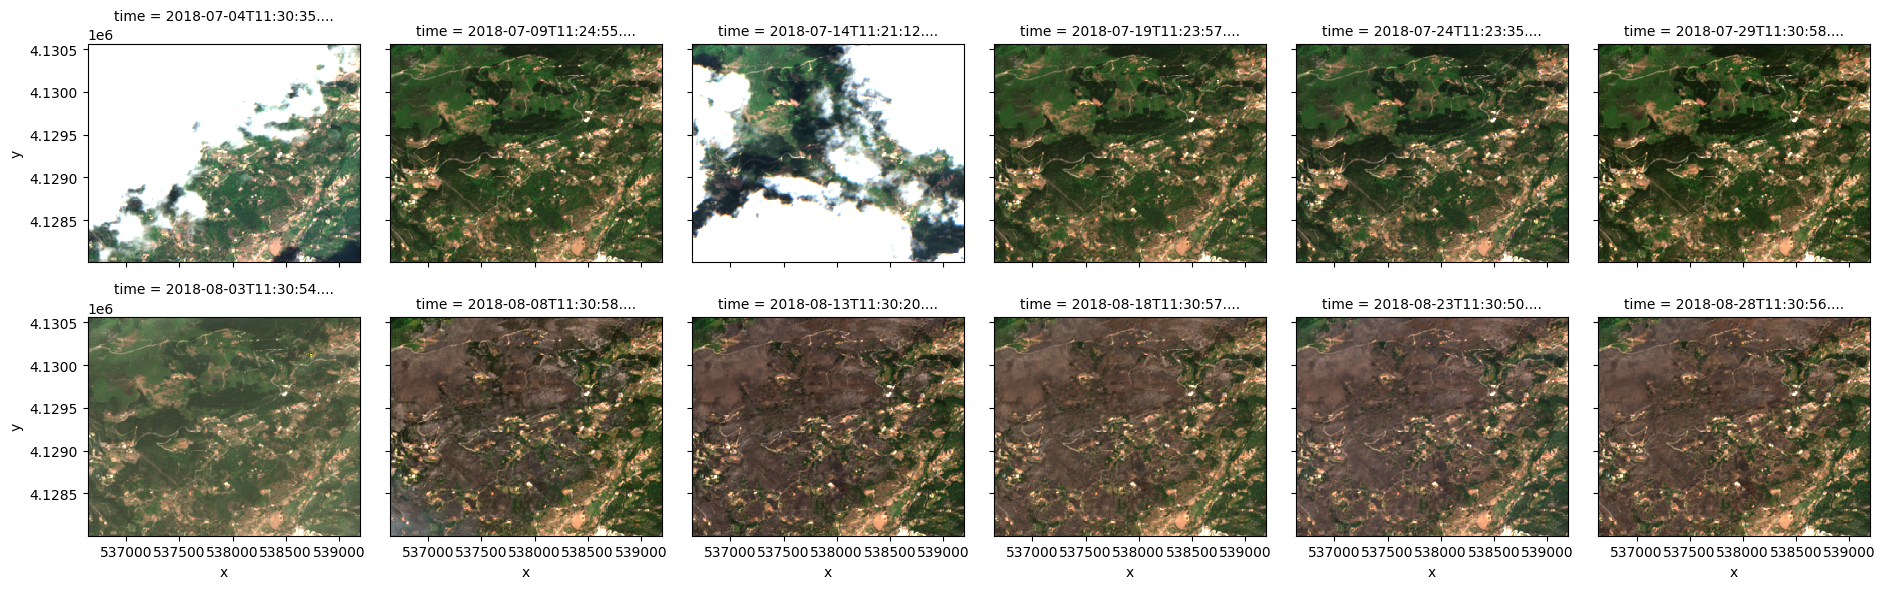

In [18]:
stack.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=6
)

In [21]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "https://clay-model-ckpt.s3.amazonaws.com/v0.5.7/mae_v0.5.7_epoch-13_val-loss-0.3098.ckpt"
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt, metadata_path="../../configs/metadata.yaml", shuffle=False, mask_ratio=0
)
model.eval()

model = model.to(device)

Downloading: "https://huggingface.co/made-with-clay/Clay/resolve/main/Clay_v0.1_epoch-24_val-loss-0.46.ckpt?download=true" to C:\Users\coach/.cache\torch\hub\checkpoints\Clay_v0.1_epoch-24_val-loss-0.46.ckpt
100%|██████████| 487M/487M [01:27<00:00, 5.84MB/s] 


FileNotFoundError: [Errno 2] No such file or directory: '../../configs/metadata.yaml'

In [ ]:
# Extract mean, std, and wavelengths from metadata
platform = "sentinel-2-l2a"
metadata = Box(yaml.safe_load(open("../../configs/metadata.yaml")))
mean = []
std = []
waves = []
# Use the band names to get the correct values in the correct order.
for band in stack.band:
    mean.append(metadata[platform].bands.mean[str(band.values)])
    std.append(metadata[platform].bands.std[str(band.values)])
    waves.append(metadata[platform].bands.wavelength[str(band.values)])

# Prepare the normalization transform function using the mean and std values.
transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)

In [ ]:
# Prep datetimes embedding using a normalization function from the model code.
def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))


datetimes = stack.time.values.astype("datetime64[s]").tolist()
times = [normalize_timestamp(dat) for dat in datetimes]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]


# Prep lat/lon embedding using the
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))


latlons = [normalize_latlon(lat, lon)] * len(times)
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

# Normalize pixels
pixels = torch.from_numpy(stack.data.astype(np.float32))
pixels = transform(pixels)

In [ ]:
# Prepare additional information
datacube = {
    "platform": platform,
    "time": torch.tensor(
        np.hstack((week_norm, hour_norm)),
        dtype=torch.float32,
        device=device,
    ),
    "latlon": torch.tensor(
        np.hstack((lat_norm, lon_norm)), dtype=torch.float32, device=device
    ),
    "pixels": pixels.to(device),
    "gsd": torch.tensor(stack.gsd.values, device=device),
    "waves": torch.tensor(waves, device=device),
}

In [ ]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

# The first embedding is the class token, which is the
# overall single embedding. We extract that for PCA below.
embeddings = unmsk_patch[:, 0, :].cpu().numpy()

In [ ]:
# Run PCA
pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(embeddings)

plt.xticks(rotation=-45)

# Plot all points in blue first
plt.scatter(stack.time, pca_result, color="blue")

# Re-plot cloudy images in green
plt.scatter(stack.time[0], pca_result[0], color="green")
plt.scatter(stack.time[2], pca_result[2], color="green")

# Color all images after fire in red
plt.scatter(stack.time[-5:], pca_result[-5:], color="red")

In [ ]:
# Label the images we downloaded
# 0 = Cloud
# 1 = Forest
# 2 = Fire
labels = np.array([0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2])

# Split into fit and test manually, ensuring we have all 3 classes in both sets
fit = [0, 1, 3, 4, 7, 8, 9]
test = [2, 5, 6, 10, 11]

# Train a Support Vector Machine model
clf = svm.SVC()
clf.fit(embeddings[fit] + 100, labels[fit])

# Predict classes on test set
prediction = clf.predict(embeddings[test] + 100)

# Perfect match for SVM
match = np.sum(labels[test] == prediction)
print(f"Matched {match} out of {len(test)} correctly")